# Anomaly Detection on a Univariate Times Series

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import set_config
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tqdm import tqdm

pd.set_option("mode.chained_assignment", None)
set_config(transform_output="pandas")

In [2]:
# User defined variables.
VAL_RATIO = 0.3
TEST_RATIO = 0.4

In [3]:
DATA_PATH = "../taxi_data.csv"

taxi_df = pd.read_csv(DATA_PATH, parse_dates=["timestamp"], index_col="timestamp")

# Save the columns because we modify them later
columns = [col for col in taxi_df.columns]

figure = plt.figure(figsize=(17, 10))
plt.plot(taxi_df)

FileNotFoundError: [Errno 2] No such file or directory: '../taxi_data.csv'

## Train/val/test Split

In [ ]:
# Train test split
X_train_raw, X_temp_raw = train_test_split(taxi_df, test_size=VAL_RATIO, shuffle=False)

# Now, split the temp set into validation and test sets
X_val_raw, X_test_raw = train_test_split(
    X_temp_raw, test_size=TEST_RATIO, shuffle=False
)

# Scale the data
# Fit the scaler on the training data
scaler = StandardScaler().fit(X_train_raw)

# Transform all three sets using the same scaler
X_train = scaler.transform(X_train_raw)
X_val = scaler.transform(X_val_raw)
X_test = scaler.transform(X_test_raw)

## Unsupervised Anomaly Detection Algorithms

Scikit-learn implementation available:
 - LOF https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.LocalOutlierFactor.html
 - IF https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.IsolationForest.html
 - OCSVM https://scikit-learn.org/stable/modules/svm.html

Torch implementation:
 - AE

In [ ]:
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM

# Create estimator
LOF = LocalOutlierFactor(
    n_neighbors=2, metric="manhattan", contamination=0.02, novelty=True
)
IF = IsolationForest(
    n_estimators=50, max_samples="auto", contamination=float(0.1), max_features=1.0
)
SVM = OneClassSVM(gamma="auto")

# Fit estimator on the training data
LOF.fit(X_train)
# Classifies points as anomalies or normal points
X_val.loc[:, "LOF_class_pred"] = LOF.predict(X_val[columns])
# Calculate the anomaly scores ( not always needed)
X_val.loc[:, "LOF_score"] = LOF.decision_function(X_val[columns])

# Repeat for isolation forest.
IF.fit(X_train)
X_val.loc[:, "IF_class_pred"] = IF.predict(X_val[columns])
X_val.loc[:, "IF_score"] = IF.decision_function(X_val[columns])

# Repeat for SVM.
SVM.fit(X_train)
X_val.loc[:, "SVM_class_pred"] = SVM.predict(X_val[columns])
X_val.loc[:, "SVM_score"] = SVM.decision_function(X_val[columns])

/home/greg/Desktop/standard_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(
/home/greg/Desktop/standard_env/lib/python3.10/site-packages/sklearn/base.py:464: UserWarning: X does not have valid feature names, but LocalOutlierFactor was fitted with feature names
  warnings.warn(


## Fully Connected Autoencoder

In [ ]:
# Auto Encoderse
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

In [ ]:
# User defined variables for the AE architecture
N_FEATURE_DIM = 48
N_LATENT_DIM = 12
N_HIDDEN = 64
BATCH_SIZE = 16
LEARNING_RATE = 0.001
EPOCHS = 5

In [ ]:
class Autoencoder(nn.Module):
    """
    An autoencoder neural network module.

    This module defines a simple feed-forward autoencoder with two main parts: the encoder and the decoder.

    Attributes:
        encoder (nn.Sequential): The encoding part of the autoencoder.
        decoder (nn.Sequential): The decoding part of the autoencoder.
    """

    def __init__(self, n_feature_dim, n_hidden, n_latent_dim):
        """
        Initialize the Autoencoder model.

        Args:
            n_feature_dim (int): Dimensionality of the input features.
            n_hidden (int): Number of hidden units for the hidden layers of the encoder and decoder.
            n_latent_dim (int): Dimensionality of the latent space (output of the encoder).
        """
        super(Autoencoder, self).__init__()

        self.encoder = nn.Sequential(
            nn.Linear(n_feature_dim, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_latent_dim),
            nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            nn.Linear(n_latent_dim, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_feature_dim),
        )

    def forward(self, x):
        """
        Forward pass of the autoencoder.

        Args:
            x (torch.Tensor): Input tensor with shape (batch_size, n_feature_dim).

        Returns:
            torch.Tensor: Reconstructed output tensor with shape (batch_size, n_feature_dim).
        """
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
# Initialising the model and creating the loss
model = Autoencoder(N_FEATURE_DIM, N_HIDDEN, N_LATENT_DIM)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.MSELoss()

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the GPU
model.to(device)

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=48, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU()
  )
  (decoder): Sequential(
    (0): Linear(in_features=12, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=48, bias=True)
  )
)

In [ ]:
class TimeSeriesDataset(Dataset):
    """
    A dataset for handling time series data.

    Use this dataset when each sample contains a contiguous time series.

    Attributes:
        X (Sequence): The entire time series data.
        forecast_horizon (int): Number of time steps to predict into the future.
        lags (int): Number of past time steps to consider as input.
    """

    def __init__(self, X, lags, forecast_horizon):
        """
        Initialize the TimeSeriesDataset.

        Args:
            X (Sequence): The entire time series data.
            forecast_horizon (int): Number of time steps to predict into the future.
            lags (int): Number of past time steps to consider as input.
        """
        self.X = X
        self.forecast_horizon = forecast_horizon
        self.lags = lags

    def __len__(self):
        """
        Calculate the length of the dataset.

        Returns:
            int: Length of the dataset, considering the lags and forecast horizon.
        """
        length = len(self.X) - self.lags - self.forecast_horizon + 1
        return length

    def __getitem__(self, idx):
        """
        Retrieve a sample from the dataset at the given index.

        The sample contains input data (x) and target data (y). The input consists
        of `lags` number of time steps from the time series, and the target
        consists of `forecast_horizon` number of time steps immediately following the input.

        Args:
            idx (int): Index of the desired sample.

        Returns:
            tuple: A tuple containing the input time series data (x) and target time series data (y).
        """
        x = self.X[idx: idx + self.lags]
        y = self.X[idx + self.lags: idx + self.lags + self.forecast_horizon]
        return x, y

In [ ]:
# Train data
train_dataset = TimeSeriesDataset(X_train.values, N_FEATURE_DIM, forecast_horizon=0)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

# Val data
val_dataset = TimeSeriesDataset(X_val[columns].values, N_FEATURE_DIM, forecast_horizon=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
# Lists to store average training and validation losses for each epoch
train_losses = []
val_losses = []

# Training the model
for epoch in tqdm(range(EPOCHS)):

    # Variable to accumulate training losses for the current epoch
    train_loss = 0.0

    # Set the model to training mode
    model.train()

    # Training loop
    for batch_X, _ in train_loader:
        batch_X = batch_X.squeeze(-1).to(device).to(torch.float32)

        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_X)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumulate the training loss
        train_loss += loss.item() * batch_X.size(0)

    # Calculate and store the average training loss for the epoch
    average_train_loss = train_loss / len(train_loader.dataset)
    train_losses.append(average_train_loss)

    # Variable to accumulate validation losses for the current epoch
    val_loss = 0.0

    # Set the model to evaluation mode
    model.eval()

    # Validation loop
    # No need to compute gradients during validation, so we wrap it with no_grad
    with torch.no_grad():
        for batch_X, _ in val_loader:

            batch_X_val = batch_X.squeeze(-1).to(device).to(torch.float32)

            outputs_val = model(batch_X_val)
            loss_val = criterion(outputs_val, batch_X_val)
            val_loss += loss_val.item() * batch_X_val.size(0)

    # Calculate and store the average validation loss for the epoch
    average_val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(average_val_loss)

    # Print the losses for the current epoch (optional)
    print(
        f"Epoch {epoch+1}/{EPOCHS}, Train Loss: {average_train_loss:.4f}, Validation Loss: {average_val_loss:.4f}"
    )

 20%|█████████                                    | 1/5 [00:00<00:03,  1.12it/s]

Epoch 1/5, Train Loss: 0.0135, Validation Loss: 0.0219



 40%|██████████████████                           | 2/5 [00:01<00:02,  1.02it/s]

Epoch 2/5, Train Loss: 0.0134, Validation Loss: 0.0210



 60%|███████████████████████████                  | 3/5 [00:03<00:02,  1.25s/it]

Epoch 3/5, Train Loss: 0.0134, Validation Loss: 0.0217



 80%|████████████████████████████████████         | 4/5 [00:04<00:01,  1.10s/it]

Epoch 4/5, Train Loss: 0.0131, Validation Loss: 0.0205


100%|█████████████████████████████████████████████| 5/5 [00:05<00:00,  1.05s/it]

Epoch 5/5, Train Loss: 0.0131, Validation Loss: 0.0206


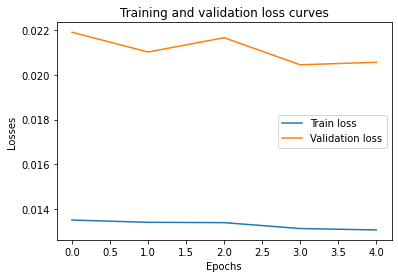

In [ ]:
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses, label="Validation loss")
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.legend()
plt.title("Training and validation loss curves")
plt.show()

In [ ]:
# Val data
val_dataset = TimeSeriesDataset(X_val[columns].values, N_FEATURE_DIM, forecast_horizon=0)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
 
reconstruction_errors_raw = []
with torch.no_grad():
    for batch_X, _ in val_loader:
 
        batch_X_val = batch_X.squeeze(-1).to(device).to(torch.float32)
 
        outputs_val = model(batch_X_val)
        batch_errors = torch.mean((outputs_val - batch_X_val)**2, dim=1)
        reconstruction_errors_raw.extend(batch_errors.cpu().numpy())

In [ ]:
ANOMALY_PERCENTILE_THRESHOLD = 90

# From the reconstruction error creating anomalies
threshold = np.percentile(reconstruction_errors, ANOMALY_PERCENTILE_THRESHOLD)
anomalies = reconstruction_errors > threshold

# Create new columns with NaN values
X_val["AE_class_pred"] = 1
X_val["AE_score"] = 1

# Assign values to the new columns using iloc for rows and column name for columns
X_val.iloc[: len(anomalies), X_val.columns.get_loc("AE_class_pred")] = np.abs(
    1 - np.array(anomalies, dtype=int)
)
X_val.iloc[: len(anomalies), X_val.columns.get_loc("AE_score")] = reconstruction_errors

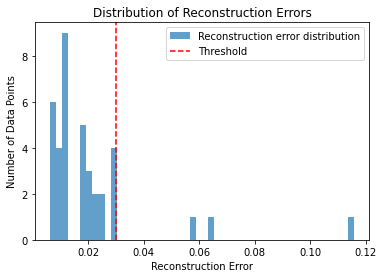

Number of Anomalous sequnces: 3


In [ ]:
# Plotting the reconstruction error as a histogram
plt.hist(
    reconstruction_errors_raw,
    bins=50,
    alpha=0.7,
    label="Reconstruction error distribution",
)
plt.axvline(x=threshold, color="r", linestyle="--", label="Threshold")

plt.title("Distribution of Reconstruction Errors")
plt.xlabel("Reconstruction Error")
plt.ylabel("Number of Data Points")
plt.legend()
plt.show()

print(f"Number of Anomalous sequnces: {sum(anomalies) // N_FEATURE_DIM}")

## Evaluation strategies

Visualisation for unlabeled anomalies

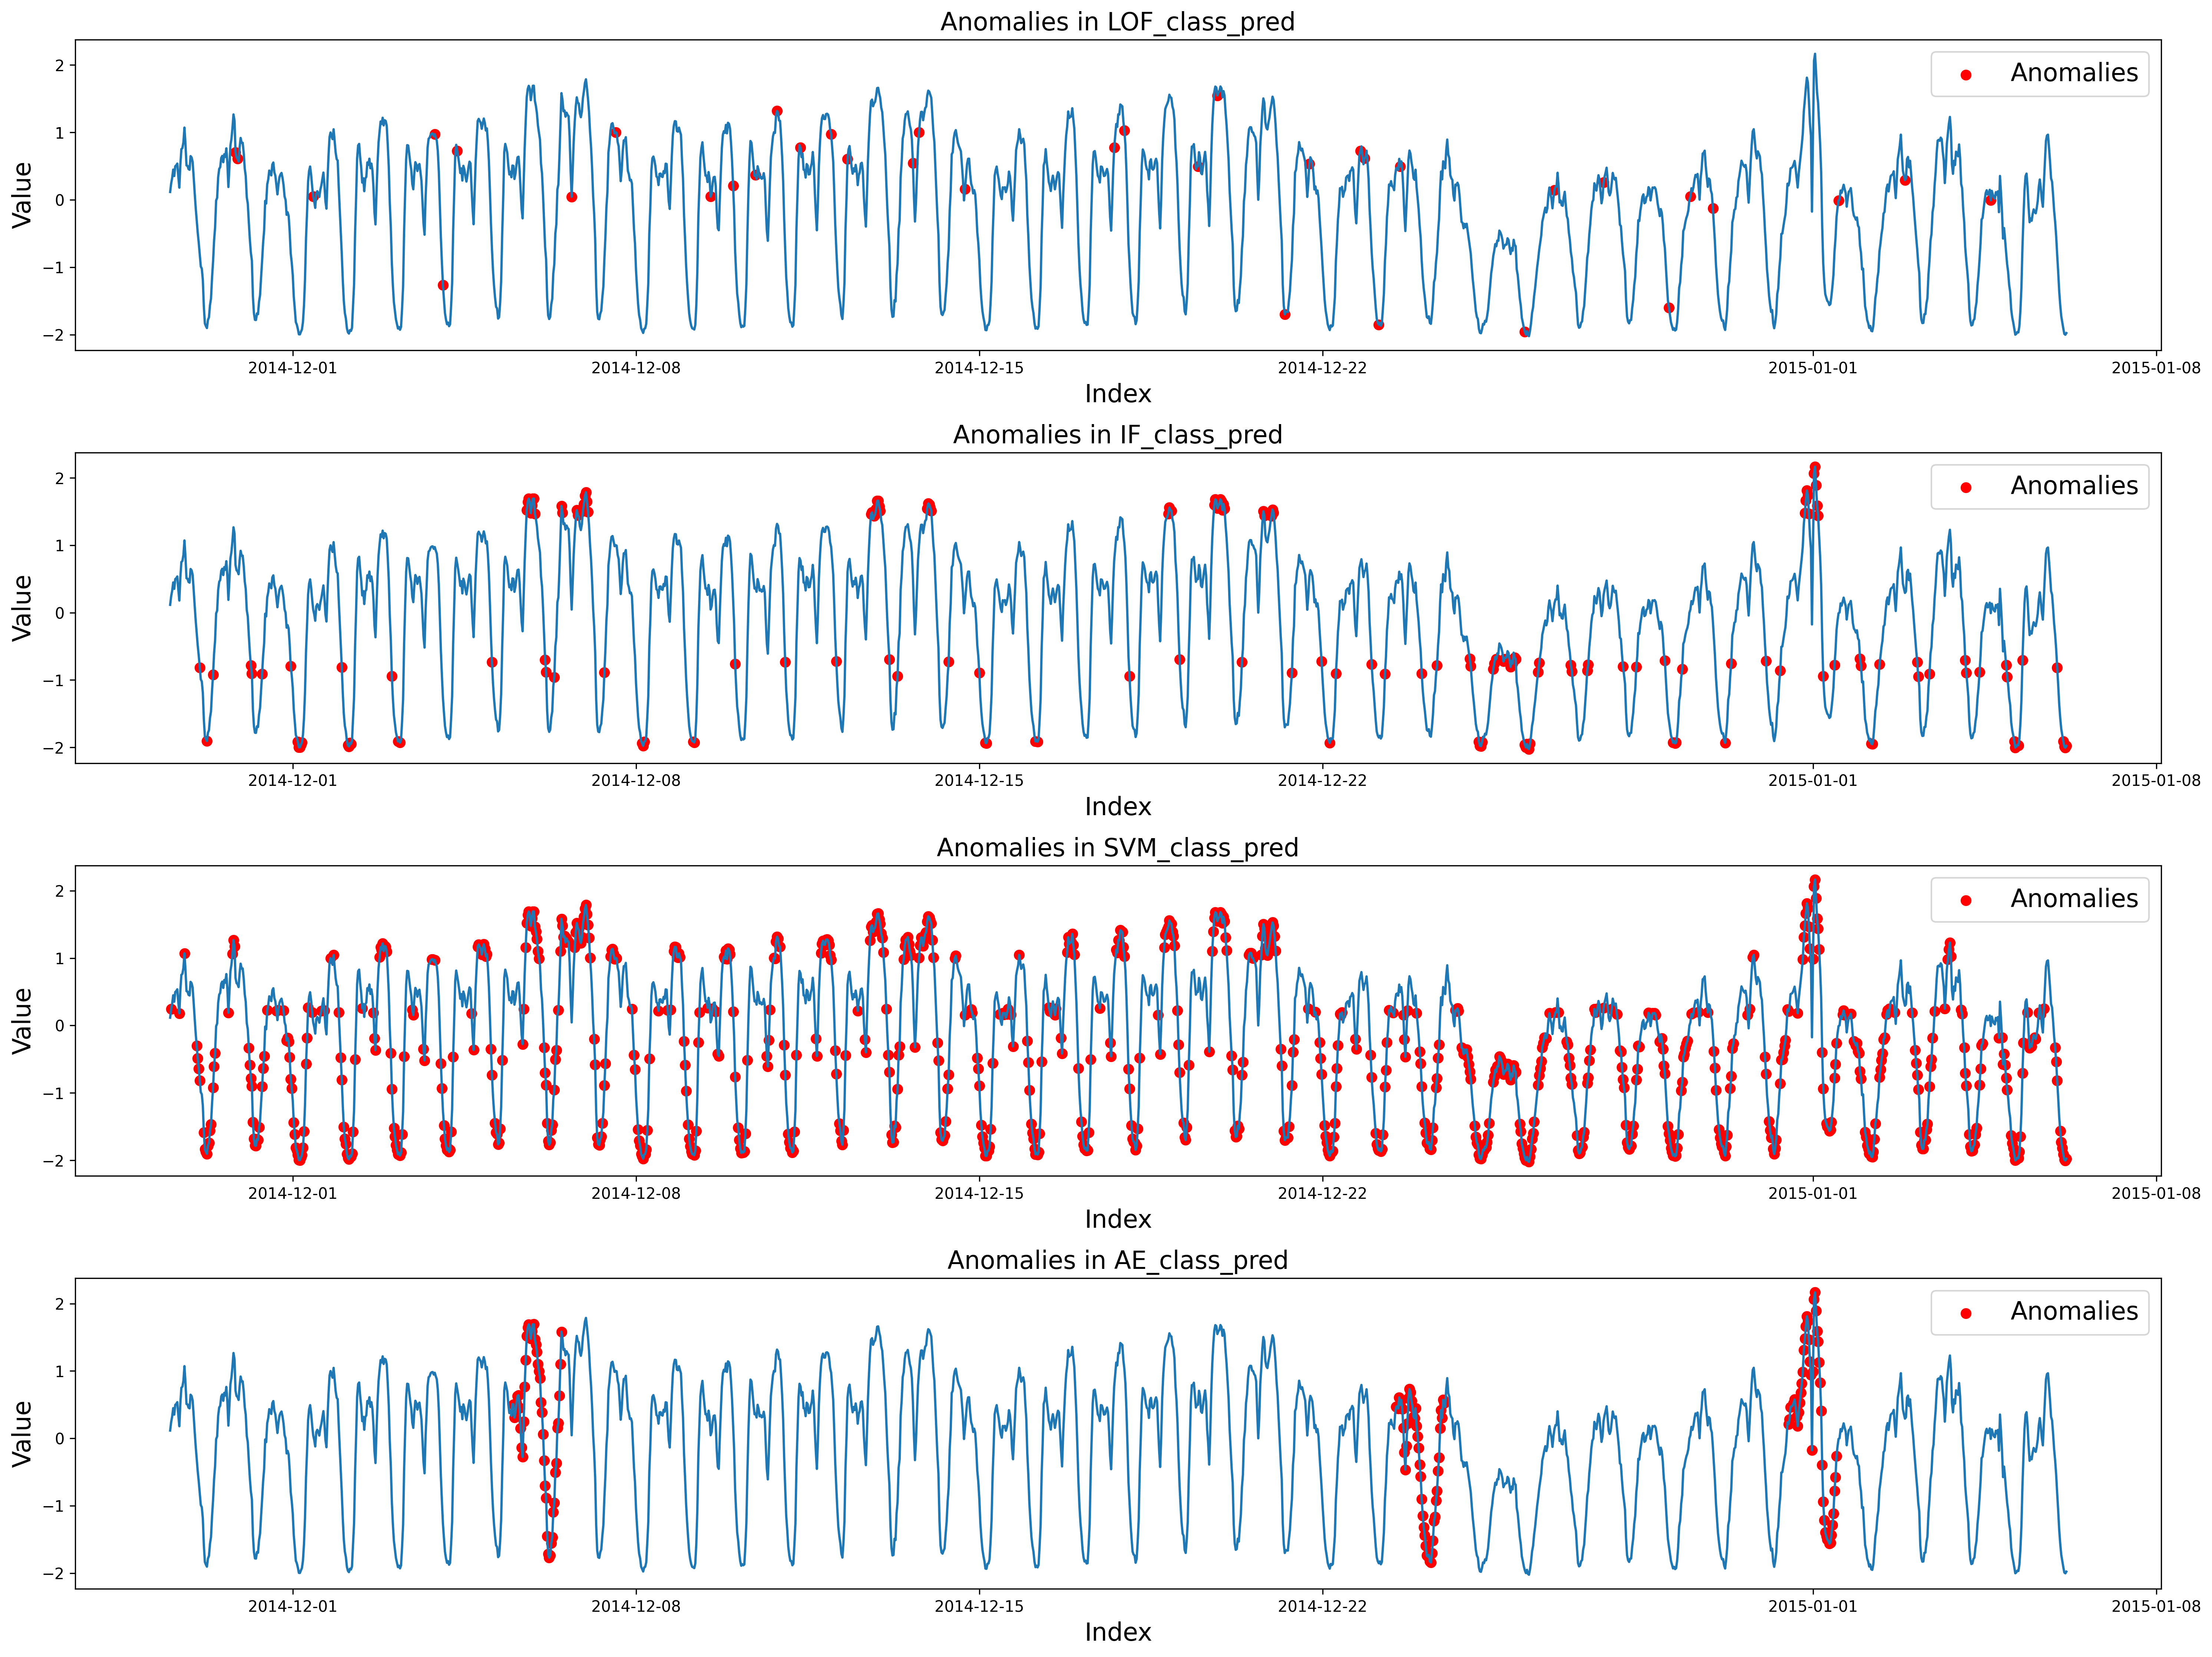

In [ ]:
# Plots that have anomalies in them
anomaly_class_columns = [col for col in X_val.columns if "class_pred" in col]
# Fill NaN values with 0 and replace -1 with 0
X_val[anomaly_class_columns] = X_val[anomaly_class_columns].replace({None: 1, -1: 0})

figure, ax = plt.subplots(len(anomaly_class_columns), figsize=(20, 15))
plt.setp(figure, dpi=300)
for i, col in enumerate(anomaly_class_columns):

    ax[i].plot(X_val["value"].index, X_val["value"])
    anom = X_val[X_val[col] == 0]
    ax[i].scatter(anom.index, anom["value"], label="Anomalies", color="red")
    ax[i].set_title(f"Anomalies in {col}", fontsize=16)
    ax[i].set_xlabel("Index", fontsize=16)
    ax[i].set_ylabel("Value", fontsize=16)
    ax[i].legend(fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
def plot_distribution_of_anomalies(df, anomaly_columns):
    """
    Plot the distribution of anomalies for the provided dataframe columns.

    This function calculates the percentage of identified anomalies in
    specified columns of the dataframe and displays the results as a bar chart.

    Args:
        df (pd.DataFrame): The input dataframe containing the anomaly data.
        anomaly_columns (list of str): The columns in the dataframe which
            represent different anomaly types or categories.

    Displays:
        A bar chart showing the percentage of identified anomalies for each
        specified column in the dataframe.

    Example:
        plot_distribution_of_anomalies(data, ['anomaly_col1', 'anomaly_col2'])
    """
    # Calculate the sum of anomalies and the percentage
    anomaly_sums = df[anomaly_columns].sum()
    anomaly_percentage = anomaly_sums / len(df) * 100

    # Plot the bar chart
    print(anomaly_percentage)
    plt.bar(anomaly_sums.index, anomaly_percentage)
    plt.title('Identified anomalies "%" in the dataset')
    plt.ylabel("Percentage (%)")
    plt.xlabel("Anomaly Columns")
    plt.xticks(rotation=45)
    plt.tight_layout()  # Adjust layout to prevent label overlap
    plt.show()

LOF_class_pred     1.992461
IF_class_pred      9.746904
SVM_class_pred    50.296177
AE_class_pred      7.754443
dtype: float64


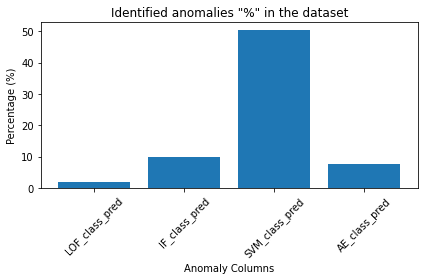

In [ ]:
# Distribution of anomalies detected vs normal data
plot_distribution_of_anomalies(X_val == 0, anomaly_class_columns)

## References

 * https://arxiv.org/pdf/2209.04635.pdf#page=80&zoom=100,424,549